# Civil Service Survival Analysis


In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lifelines as sa

from pathlib import Path
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index, k_fold_cross_validation
from lifelines.plotting import plot_lifetimes
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from scipy.stats import alpha

# Load in Dummy Data

In [41]:
data_path = 'data/indian_liver_patient.csv'

In [310]:
data = pd.read_csv(data_path)

In [311]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
Age                           583 non-null int64
Gender                        583 non-null object
Total_Bilirubin               583 non-null float64
Direct_Bilirubin              583 non-null float64
Alkaline_Phosphotase          583 non-null int64
Alamine_Aminotransferase      583 non-null int64
Aspartate_Aminotransferase    583 non-null int64
Total_Protiens                583 non-null float64
Albumin                       583 non-null float64
Albumin_and_Globulin_Ratio    579 non-null float64
Dataset                       583 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [313]:
data['Gender'] = (data['Gender']=='Male').astype(int)  # make gender an integer

Generate dummy categorical variable

In [314]:
alpha_params = (1.5, -20, 100)
hair_colour_pdf = alpha.pdf(range(100), *alpha_params)

In [315]:
['Distribution of hair colour'] + hair_colour_labels

['Distribution of hair colour', 'gold', 'brown', 'red', 'black']

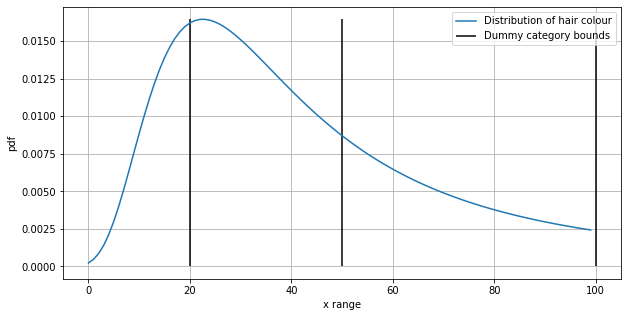

In [316]:
plt.rcParams['figure.figsize'] = 10, 5
plt.plot(hair_colour_pdf)
plt.vlines([20, 50, 100], ymin=0, ymax=hair_colour_pdf.max())
plt.legend(['Distribution of hair colour', 'Dummy category bounds'])
plt.grid()
plt.ylabel('pdf')
plt.xlabel('x range')
plt.show()

In [317]:
data['Dummy_Category'] = alpha.rvs(*alpha_params, size=data.shape[0]).clip(max=100, min=0)

In [318]:
data['Dummy_Category'] = pd.cut(data['Dummy_Category'], [0, 20, 50, 100], labels=['red', 'orange', 'yellow'])

In [319]:
target_variable = 'Age'
features = [col for col in data.columns if col is not target_variable] + ['Hair_Colour']

In [320]:
features

['Age',
 'Gender',
 'Total_Bilirubin',
 'Direct_Bilirubin',
 'Alkaline_Phosphotase',
 'Alamine_Aminotransferase',
 'Aspartate_Aminotransferase',
 'Total_Protiens',
 'Albumin',
 'Albumin_and_Globulin_Ratio',
 'Dataset',
 'Dummy_Category',
 'Hair_Colour']

Stratify based on yes/no liver 

In [321]:
n_folds, cols = 3, features
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
kfold_indices = list(skf.split(X=data, 
                               y=data['Dataset']))

In [322]:
data['Observed'] = 1

In [326]:
data.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
Dummy_Category                0
Observed                      0
dtype: int64

In [336]:
data.dropna(inplace=True)

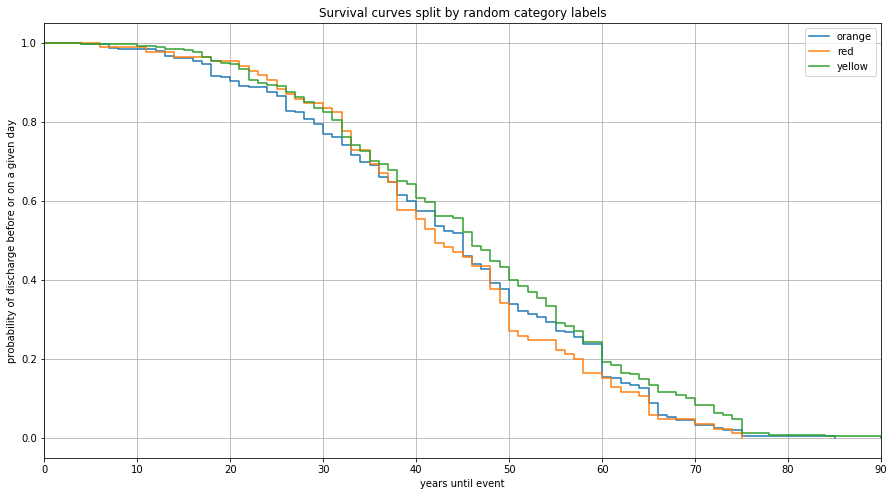

In [337]:
plt.rcParams['figure.figsize'] = 15, 8

ax = -1

for cat in data['Dummy_Category'].unique():
    kmf = KaplanMeierFitter()
    d = data[data['Dummy_Category']==cat]
    kmf.fit(d[target_variable], event_observed=d['Observed'], label=cat)
    if ax==-1:
        ax=kmf.plot(ci_show=False)
    else:
        kmf.plot(ax=ax, ci_show=False)
plt.ylabel('probability of discharge before or on a given day')
plt.xlabel('years until event')
plt.title(f'Survival curves split by random category labels')
plt.grid()
plt.show()

In [338]:
from lifelines import CoxPHFitter, ExponentialFitter, NelsonAalenFitter

In [339]:
cpf = CoxPHFitter()
cpf.fit(data.drop('Dummy_Category', axis=1), duration_col='Age', event_col='Observed')

<lifelines.CoxPHFitter: fitted with 579 observations, 0 censored>

In [340]:
cpf.print_summary()


<lifelines.CoxPHFitter: fitted with 579 observations, 0 censored>
      duration col = 'Age'
         event col = 'Observed'
number of subjects = 579
  number of events = 579
partial log-likelihood = -3081.13
  time fit was run = 2019-09-18 21:34:43 UTC

---
                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
Gender                     -0.08      0.93      0.10           -0.27            0.12                0.76                1.13
Total_Bilirubin             0.00      1.00      0.01           -0.02            0.03                0.98                1.03
Direct_Bilirubin            0.03      1.03      0.03           -0.03            0.09                0.97                1.10
Alkaline_Phosphotase       -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Alamine_Aminotransferase    0.00      1.00      0.00            0.00            0.00                1.00            

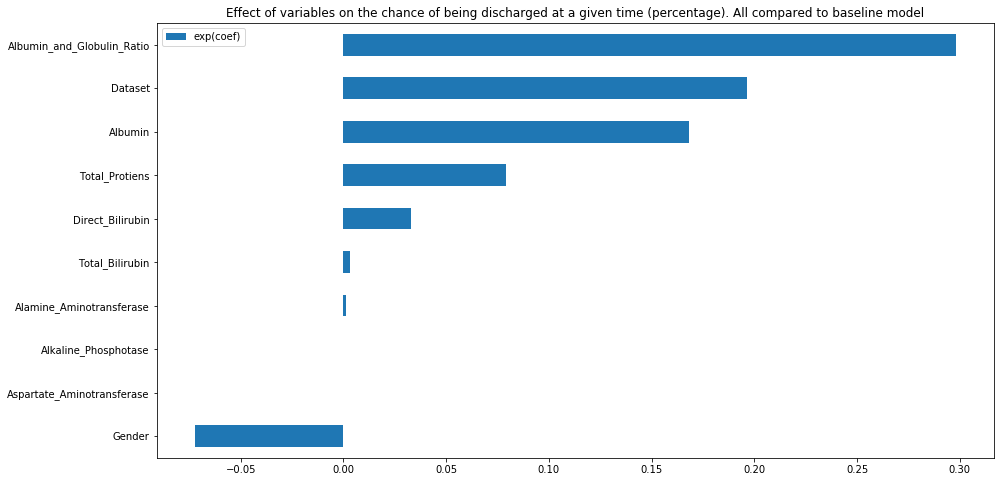

In [341]:
(cpf.summary[['exp(coef)']] - 1).sort_values('exp(coef)').plot.barh()
plt.title('Effect of variables on the chance of being discharged at a given time (percentage). All compared to baseline model')
plt.show()

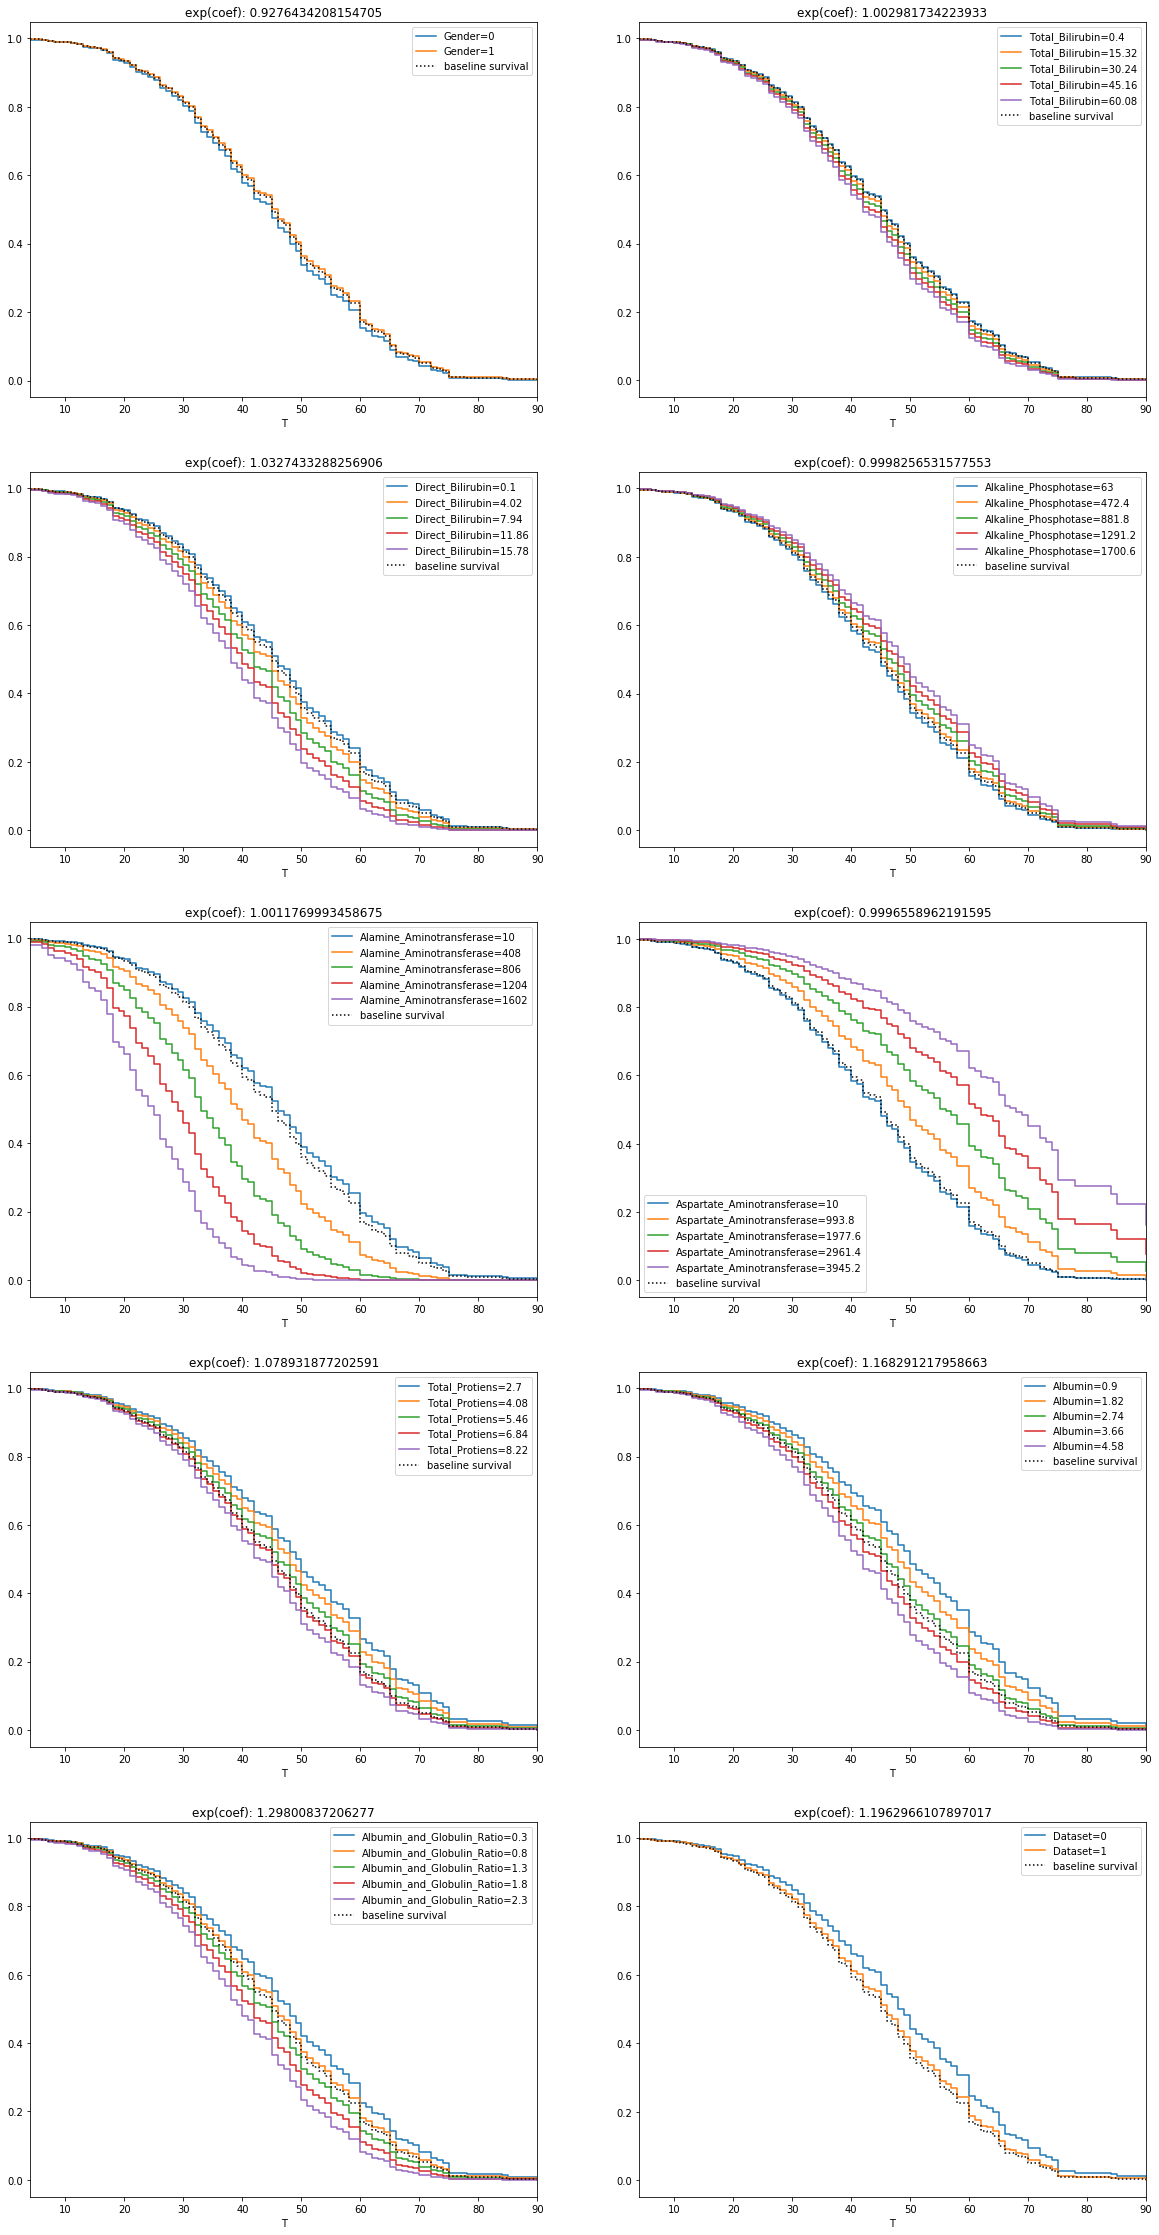

In [357]:
vars_to_isolate = data.drop(['Dummy_Category', 'Age', 'Observed'], axis=1).columns.values

ncols = 2
nrows = int(np.ceil(len(vars_to_isolate)*(1./ncols)))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,40))

for ivar, var in enumerate(vars_to_isolate):
    if len(data[var].unique()) == 2:
        range_of_values = [0, 1]
    else:
        range_of_values = np.arange(data[var].min(), data[var].max(), (data[var].max()-data[var].min())/5)
    x1, x2 = divmod(ivar, ncols)
    cpf.plot_covariate_groups(var, range_of_values, ax=axes[x1, x2])
    axes[x1, x2].set_title(f'exp(coef): {cpf.summary.loc[var, "exp(coef)"]}')
plt.show()